### Load modules

In [5]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction import DictVectorizer


## Exploratory Data Analysis

In [6]:
df = pd.read_csv('./data/ai_job_dataset.csv')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   job_id                  15000 non-null  object 
 1   job_title               15000 non-null  object 
 2   salary_usd              15000 non-null  int64  
 3   salary_currency         15000 non-null  object 
 4   experience_level        15000 non-null  object 
 5   employment_type         15000 non-null  object 
 6   company_location        15000 non-null  object 
 7   company_size            15000 non-null  object 
 8   employee_residence      15000 non-null  object 
 9   remote_ratio            15000 non-null  int64  
 10  required_skills         15000 non-null  object 
 11  education_required      15000 non-null  object 
 12  years_experience        15000 non-null  int64  
 13  industry                15000 non-null  object 
 14  posting_date            15000 non-null

1. Dataset size:
    The dataset contains 15,000 rows and 19 columns — a manageable size for EDA and model training.

2. Missing values:
    All columns are fully populated (15000 non-null), meaning no missing data — excellent data quality.

3. Data types:
    - 14 object columns — categorical or text fields.
    - 4 int64 columns — likely numeric or coded features.
    - 1 float64 column (benefits_score).
    This shows that the dataset is categorical-heavy, requiring encoding before modeling.

4. Target variable:
    salary_usd is integer and complete — perfect for a regression problem.

In [8]:
df.head()

,job_id,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,AI00001,AI Research Scientist,90376,USD,SE,CT,China,M,China,50,"Tableau, PyTorch, Kubernetes, Linux, NLP",Bachelor,9,Automotive,2024-10-18,2024-11-07,1076,5.9,Smart Analytics
1,AI00002,AI Software Engineer,61895,USD,EN,CT,Canada,M,Ireland,100,"Deep Learning, AWS, Mathematics, Python, Docker",Master,1,Media,2024-11-20,2025-01-11,1268,5.2,TechCorp Inc
2,AI00003,AI Specialist,152626,USD,MI,FL,Switzerland,L,South Korea,0,"Kubernetes, Deep Learning, Java, Hadoop, NLP",Associate,2,Education,2025-03-18,2025-04-07,1974,9.4,Autonomous Tech
3,AI00004,NLP Engineer,80215,USD,SE,FL,India,M,India,50,"Scala, SQL, Linux, Python",PhD,7,Consulting,2024-12-23,2025-02-24,1345,8.6,Future Systems
4,AI00005,AI Consultant,54624,EUR,EN,PT,France,S,Singapore,100,"MLOps, Java, Tableau, Python",Master,0,Media,2025-04-15,2025-06-23,1989,6.6,Advanced Robotics


1. snake_case format for column names — good
2. dont need job_id
3. categorical field values like job_title, company_location, and education_required are inconsistent:
    - mixed capitalization (e.g., AI Engineer, ai engineer);
    - spaces instead of underscores;
    - sometimes contain symbols or slashes (e.g., MLOps / Data Engineer).
4. required_skills - this column represents a multi-label categorical feature — a comma-separated list of skills. It should be preprocessed differently since it encodes multiple labels per sample, not just one.

In [9]:
# 2. don't need the id column
df = df[list(df.columns)[1:]]

In [10]:
# 3. Identify categorical columns
strings = list(df.dtypes[df.dtypes == 'object'].index)
strings.remove("required_skills")
strings

['job_title',
 'salary_currency',
 'experience_level',
 'employment_type',
 'company_location',
 'company_size',
 'employee_residence',
 'education_required',
 'industry',
 'posting_date',
 'application_deadline',
 'company_name']

In [11]:
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [12]:
# 4. Preprocess the required_skills column
df['required_skills'] = (
    df['required_skills']
    .astype(str)
    .str.lower()
    .str.strip()
    .str.replace(r'\s*,\s*', ',', regex=True)   # remove extra spaces around commas
    .str.replace(r'[^a-z0-9,]', '', regex=True) # remove special chars
    .apply(lambda x: x.split(',') if x else [])
)

# Preview one example
df['required_skills'].head()

0          [tableau, pytorch, kubernetes, linux, nlp]
1    [deeplearning, aws, mathematics, python, docker]
2       [kubernetes, deeplearning, java, hadoop, nlp]
3                         [scala, sql, linux, python]
4                      [mlops, java, tableau, python]
Name: required_skills, dtype: object

In [13]:
# Final preview of cleaned dataframe
df.head()

,job_title,salary_usd,salary_currency,experience_level,employment_type,company_location,company_size,employee_residence,remote_ratio,required_skills,education_required,years_experience,industry,posting_date,application_deadline,job_description_length,benefits_score,company_name
0,ai_research_scientist,90376,usd,se,ct,china,m,china,50,"[tableau, pytorch, kubernetes, linux, nlp]",bachelor,9,automotive,2024-10-18,2024-11-07,1076,5.9,smart_analytics
1,ai_software_engineer,61895,usd,en,ct,canada,m,ireland,100,"[deeplearning, aws, mathematics, python, docker]",master,1,media,2024-11-20,2025-01-11,1268,5.2,techcorp_inc
2,ai_specialist,152626,usd,mi,fl,switzerland,l,south_korea,0,"[kubernetes, deeplearning, java, hadoop, nlp]",associate,2,education,2025-03-18,2025-04-07,1974,9.4,autonomous_tech
3,nlp_engineer,80215,usd,se,fl,india,m,india,50,"[scala, sql, linux, python]",phd,7,consulting,2024-12-23,2025-02-24,1345,8.6,future_systems
4,ai_consultant,54624,eur,en,pt,france,s,singapore,100,"[mlops, java, tableau, python]",master,0,media,2025-04-15,2025-06-23,1989,6.6,advanced_robotics


### Missing values

In [14]:
# Check for missing values
df.isna().sum()

job_title                 0
salary_usd                0
salary_currency           0
experience_level          0
employment_type           0
company_location          0
company_size              0
employee_residence        0
remote_ratio              0
required_skills           0
education_required        0
years_experience          0
industry                  0
posting_date              0
application_deadline      0
job_description_length    0
benefits_score            0
company_name              0
dtype: int64

Nice, has no missing values

In [15]:
# target = 'salary_in_usd'

In [16]:
# cat_columns = df.select_dtypes(include=['object']).columns.tolist()
# cat_columns = [cols for cols in cat_columns if cols != target]
# cat_columns

In [17]:
# # Сheck unique values of categorical columns
# for cols in cat_columns:
#     print(cols)
#     print(df[cols].value_counts())
#     print()

### Numeric features: distributions

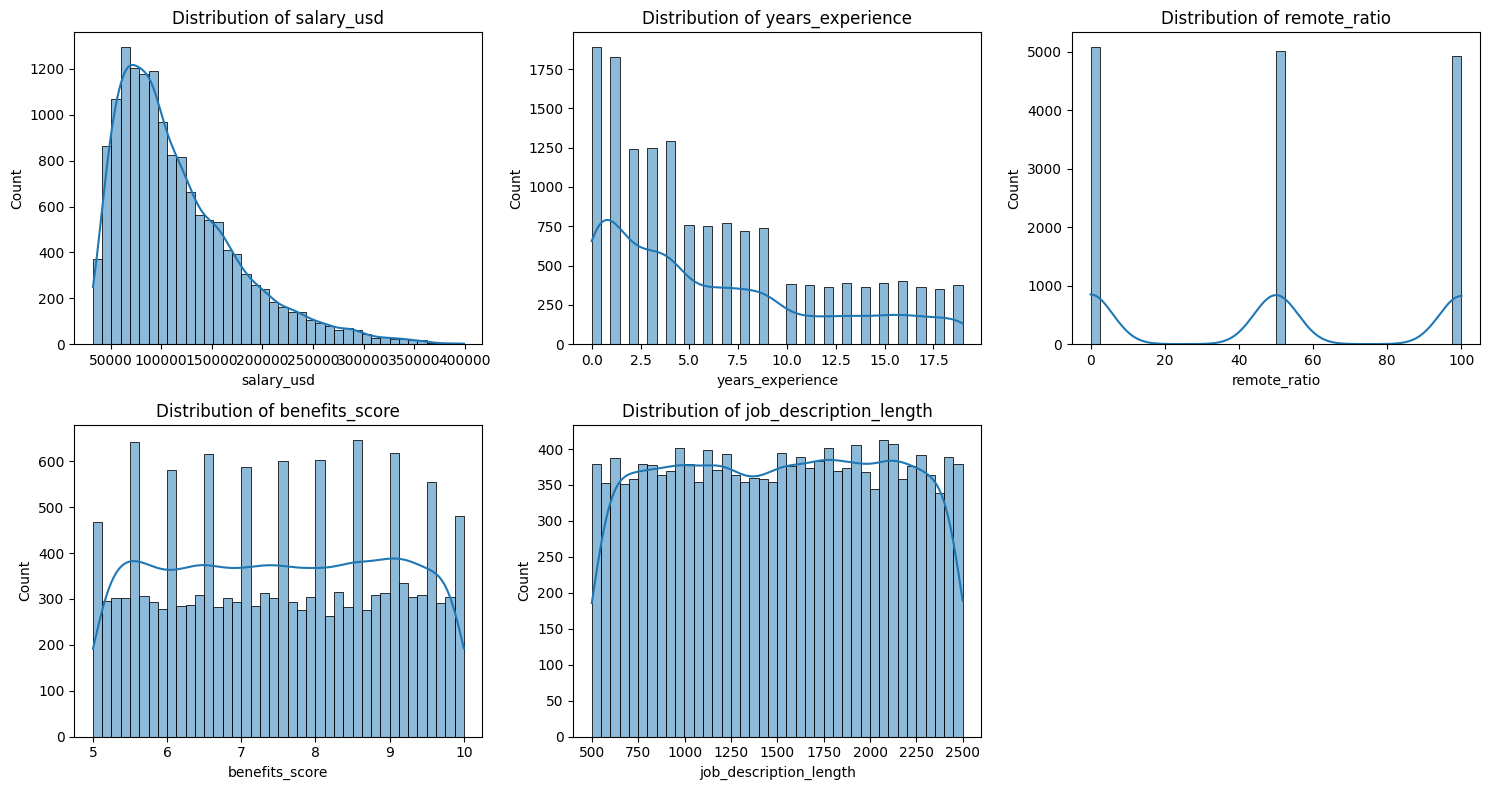

In [18]:

import matplotlib.pyplot as plt
import seaborn as sns

numeric_cols = [
    "salary_usd",
    "years_experience",
    "remote_ratio",
    "benefits_score",
    "job_description_length"
]

plt.figure(figsize=(15, 8))
for i, col in enumerate(numeric_cols, start=1):
    plt.subplot(2, 3, i)
    sns.histplot(data=df, x=col, bins=40, kde=True)
    plt.title(f"Distribution of {col}")
plt.tight_layout()
plt.show()


### Numeric correlation heatmap

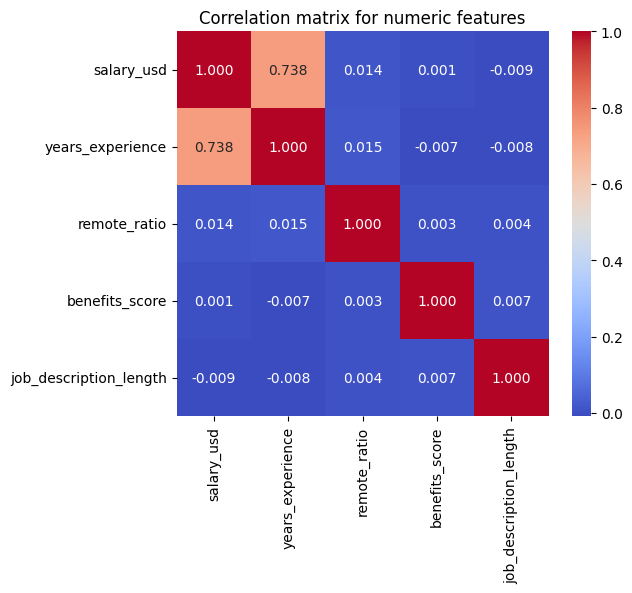

salary_usd                1.000000
years_experience          0.737556
remote_ratio              0.013727
benefits_score            0.000985
job_description_length   -0.009092
Name: salary_usd, dtype: float64

In [19]:

corr = df[numeric_cols].corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Correlation matrix for numeric features")
plt.show()

corr["salary_usd"].sort_values(ascending=False)


| Pair                          | Corr      | Interpretation                                                        |
| ----------------------------- | --------- | --------------------------------------------------------------------- |
| salary_usd ↔ years_experience | **0.74**  | **Strong positive correlation** — experience strongly affects salary. |
| salary_usd ↔ remote_ratio     | **0.014** | **Almost no relationship** — remote work doesn’t impact pay directly. |
| salary_usd ↔ benefits_score   | **0.001** | **No correlation** — benefits level is independent of pay.            |


### Categorical features

In [38]:

cat_features = [
    "experience_level",
    "employment_type",
    "company_size",
    "industry",
    "company_location",
    'job_title', 
    'remote_ratio'
]

summary_tables = {}
for col in cat_features:
    if col in df.columns:
        summary = (
            df.groupby(col)["salary_usd"]
            .agg(["count", "mean", "median", "min", "max"])
            .sort_values("mean", ascending=False)
        )
        summary_tables[col] = summary
        print(f"\n=== salary_usd by {col} ===")
        display(summary)



=== salary_usd by experience_level ===


,count,mean,median,min,max
experience_level,,,,,
ex,3760,187723.647340,177512.0,86536,399095
se,3741,122187.657845,116907.0,64824,247271
mi,3781,87955.471833,84641.0,45900,177470
en,3718,63133.377084,60373.5,32519,131006



=== salary_usd by employment_type ===


,count,mean,median,min,max
employment_type,,,,,
ft,3812,116338.137723,100421.5,32519,390292
ct,3721,115918.919645,100445.0,33117,398084
fl,3758,114967.645290,99603.5,32587,379418
pt,3709,114146.881909,98201.0,32542,399095



=== salary_usd by company_size ===


,count,mean,median,min,max
company_size,,,,,
l,4998,130322.451781,114564.0,41438,399095
m,4995,113600.237037,98122.0,36066,359597
s,5007,102146.930098,89648.0,32519,322318



=== salary_usd by industry ===


,count,mean,median,min,max
industry,,,,,
consulting,1020,117602.142157,100983.5,33172,371087
manufacturing,962,116162.888773,100007.0,33314,364585
media,1045,116127.730144,100272.0,33376,353055
education,956,116026.803347,101097.5,33280,346789
real_estate,1007,115919.095333,98126.0,32587,394917
technology,1011,115831.823937,99539.0,33546,383142
government,998,115694.321643,101914.5,33804,343803
finance,984,115323.398374,101409.0,32542,350761
telecommunications,997,115291.411234,102408.0,32666,339526



=== salary_usd by company_location ===


,count,mean,median,min,max
company_location,,,,,
switzerland,746,170639.085791,152901.0,65416,399095
denmark,778,165652.249357,147504.5,59596,379418
norway,721,159490.533981,142386.0,59644,362503
united_states,724,146833.045580,128606.0,54512,344471
united_kingdom,729,128720.186557,115281.0,48743,310470
singapore,764,128004.035340,115122.0,48797,306266
netherlands,731,126750.451436,112202.0,49800,309752
sweden,752,123559.753989,109435.0,46713,292870
germany,814,121810.143735,106923.0,46230,291446



=== salary_usd by job_title ===


,count,mean,median,min,max
job_title,,,,,
ai_specialist,728,120570.758242,103626.5,34174,390292
machine_learning_engineer,772,118827.919689,103687.0,34286,344427
head_of_ai,765,118542.968627,102025.0,32907,361718
ai_research_scientist,756,117897.925926,100990.0,33092,394917
ai_architect,771,117436.513619,99888.0,33220,398084
robotics_engineer,759,116470.793149,100714.0,32692,346789
principal_data_scientist,734,116305.219346,98712.0,33185,364635
research_scientist,742,116066.502695,99446.5,34179,339526
data_engineer,749,115970.720961,104447.0,33951,359044



=== salary_usd by remote_ratio ===


,count,mean,median,min,max
remote_ratio,,,,,
100,4920,116160.545935,100614.0,32519,398084
50,5005,115776.806793,99295.0,32542,394917
0,5075,114140.231133,98817.0,32666,399095


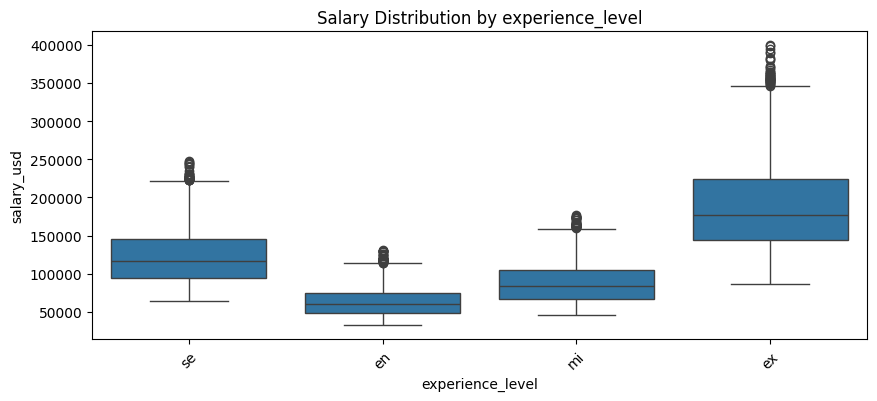

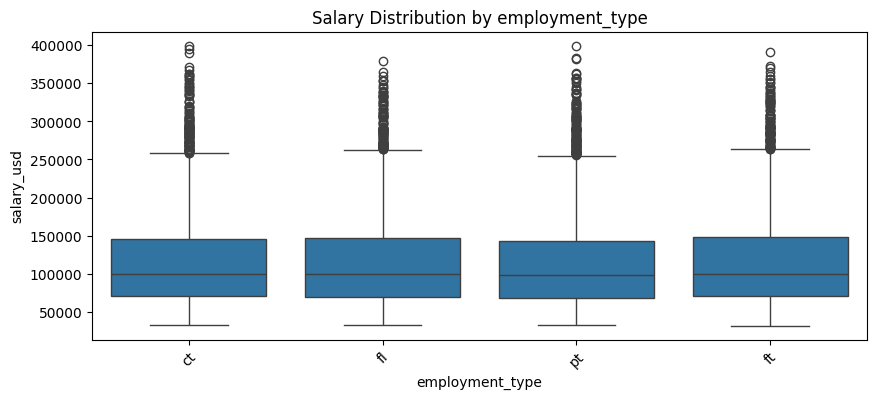

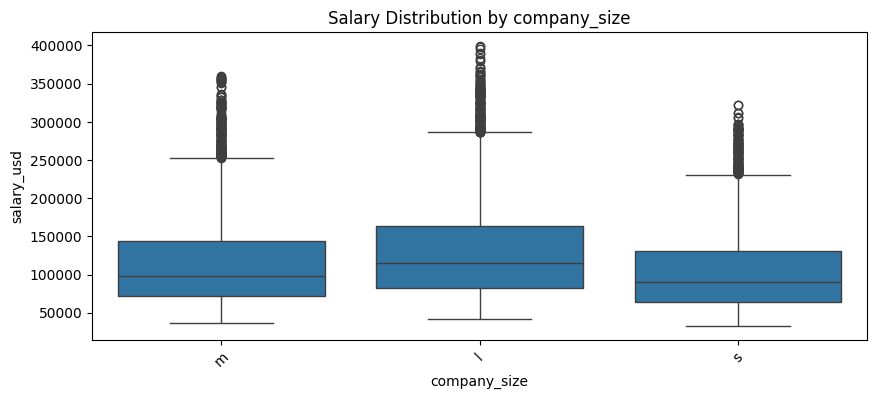

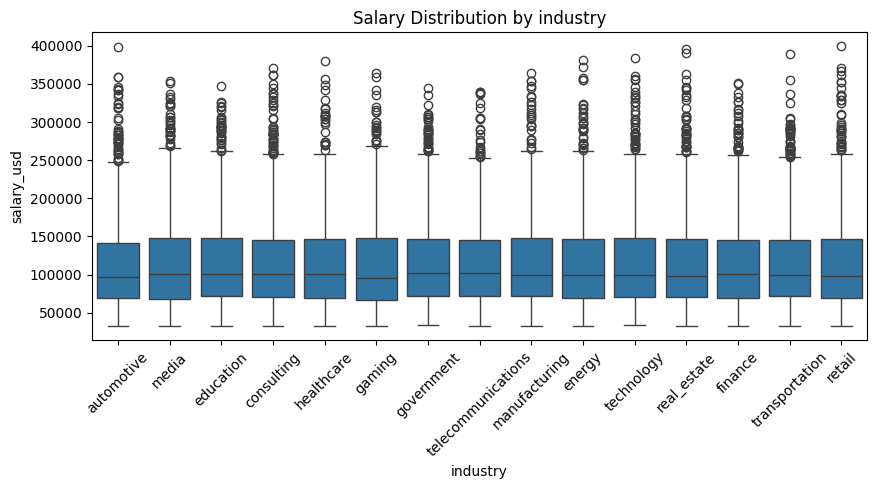

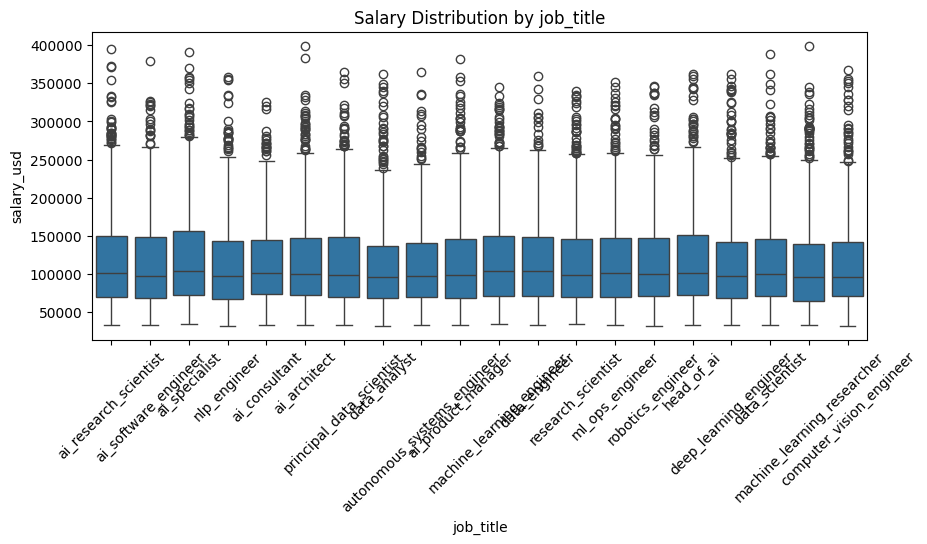

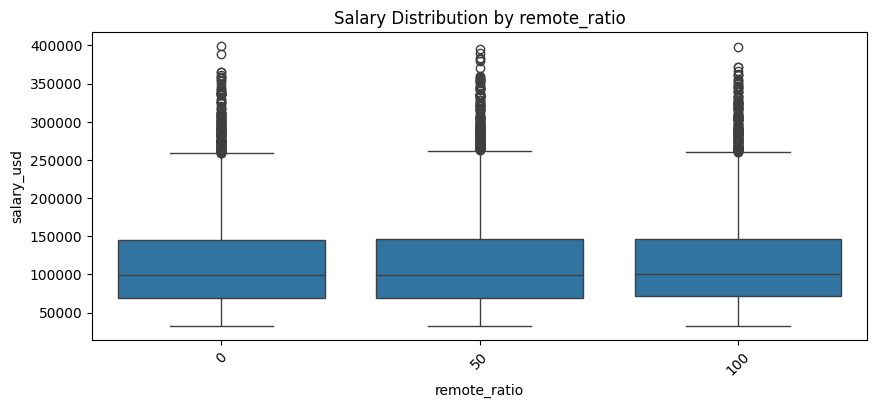

In [43]:
cat_columns = ['experience_level', 'employment_type', 'company_size', 'industry', 'job_title', 'remote_ratio']

for col in cat_columns:
    plt.figure(figsize=(10,4))
    sns.boxplot(x=col, y='salary_usd', data=df)
    plt.title(f"Salary Distribution by {col}")
    plt.xticks(rotation=45)
    plt.show()

*Experience Level*

- Salaries increase consistently with experience level. This confirms that experience_level is one of the strongest predictors of salary.

*Employment Type*

 - Median salaries are close to 100K USD in all groups.

*Company Size*
 - Large companies (L) tend to pay slightly higher salaries on average than Medium (M) and Small (S) ones.
 - However, the differences are not extreme — all medians cluster near 100–120K USD.

*Industr*
 - Median salaries are relatively consistent across all industries.

*Job Title*
 - Suggests that job seniority and leadership roles, not just technical titles, drive higher pay.

*Remote Ratio*
 - Salary distributions for all positions are almost identical.


### Text feature analysis: required_skills

,skill,count
0,python,4450
1,sql,3407
2,tensorflow,3022
3,kubernetes,3009
4,scala,2794
5,pytorch,2777
6,linux,2705
7,git,2631
8,java,2578
9,gcp,2442


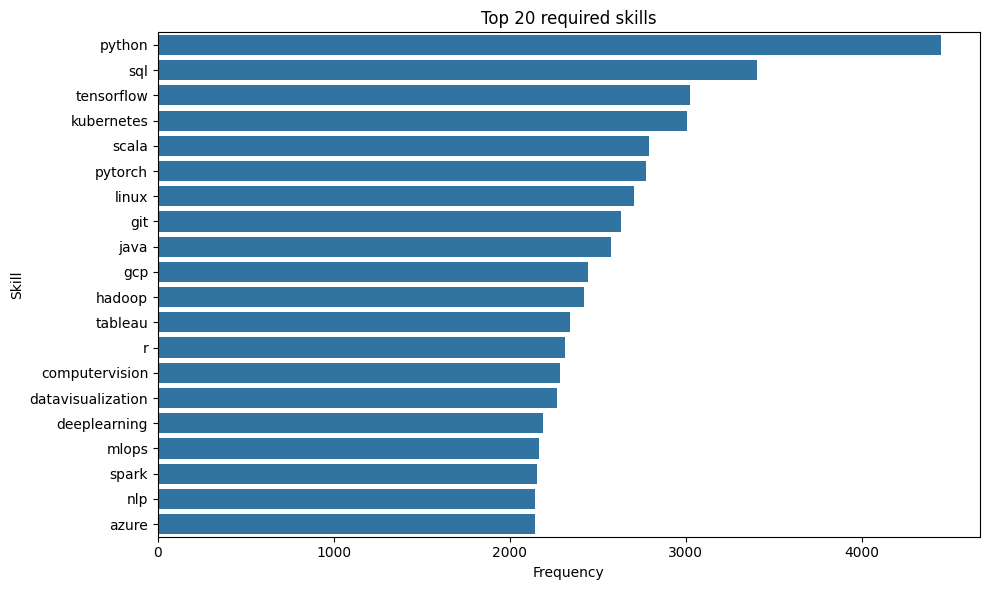

In [40]:

from collections import Counter

skills_series = df["required_skills"]    
all_skills = []
for row in skills_series:
    all_skills.extend(row)

skill_counts = Counter(all_skills)
top_skills = skill_counts.most_common(20)

top_skills_df = pd.DataFrame(top_skills, columns=["skill", "count"])
display(top_skills_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=top_skills_df, x="count", y="skill")
plt.title("Top 20 required skills")
plt.xlabel("Frequency")
plt.ylabel("Skill")
plt.tight_layout()
plt.show()


#### Word cloud for required skills

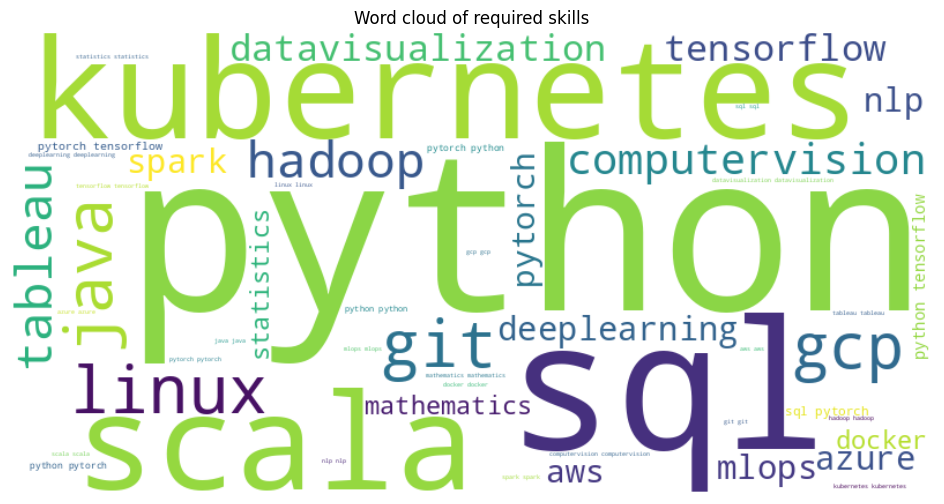

In [41]:
from wordcloud import WordCloud

skills_text = " ".join(all_skills)
wc = WordCloud(width=800, height=400, background_color="white").generate(skills_text)

plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word cloud of required skills")
plt.show()

### Model-based feature importance (RandomForestRegressor)

,feature,importance
1165,years_experience,0.558834
561,company_location=switzerland,0.040473
580,company_size=l,0.034265
614,experience_level=se,0.033261
548,company_location=denmark,0.031703
557,company_location=norway,0.029874
1164,salary_currency=usd,0.028784
563,company_location=united_states,0.028266
612,experience_level=ex,0.022507
611,experience_level=en,0.021868


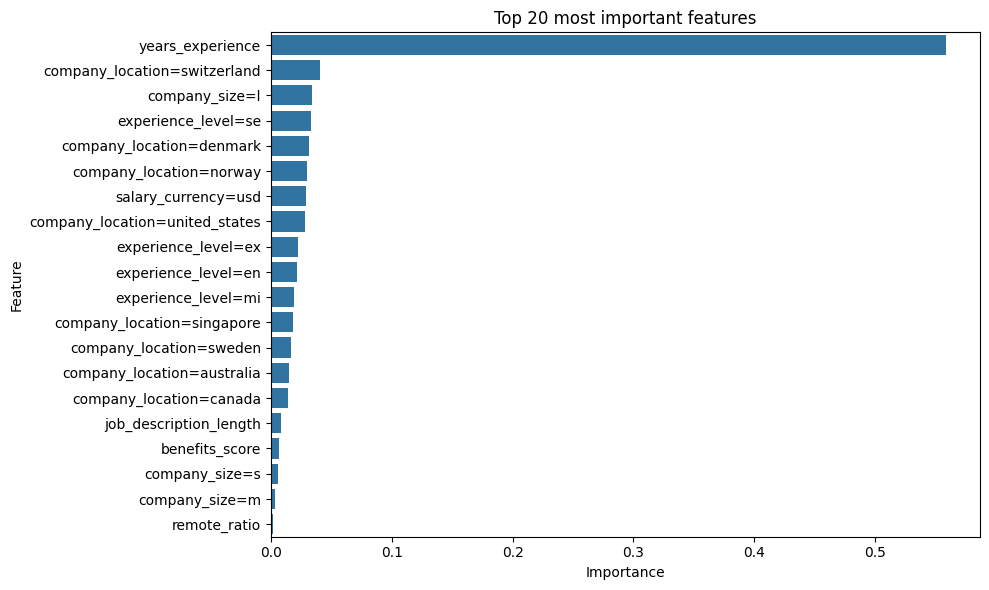

In [23]:

import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestRegressor

# For this feature-importance EDA we train on the full dataset
df_eda = df.copy()

# Target: log-transformed salary to reduce skewness
y_eda = np.log1p(df_eda["salary_usd"].values)

# Drop obvious non-feature columns if needed (adjust as necessary)
drop_cols = ["salary_usd"]
feature_df = df_eda.drop(columns=drop_cols, errors="ignore")

# Convert to dicts for DictVectorizer (handles numeric + categorical together)
dicts_eda = feature_df.to_dict(orient="records")

dv_eda = DictVectorizer(sparse=False)
X_eda = dv_eda.fit_transform(dicts_eda)

rf_eda = RandomForestRegressor(
    n_estimators=100,
    random_state=1,
    n_jobs=-1
)
rf_eda.fit(X_eda, y_eda)

importances = rf_eda.feature_importances_
feature_names = dv_eda.get_feature_names_out()

fi_df = (
    pd.DataFrame({"feature": feature_names, "importance": importances})
    .sort_values("importance", ascending=False)
    .head(20)
)

display(fi_df)

plt.figure(figsize=(10, 6))
sns.barplot(data=fi_df, x="importance", y="feature")
plt.title("Top 20 most important features")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()



### EDA summary

Key insights from the extended EDA:

- **Salary distribution**: `salary_usd` is strongly right-skewed, with most salaries in the mid-range and a long tail of high-paying roles. Using `log1p(salary_usd)` as the target helps stabilize the variance.
- **Numeric features**: `years_experience` shows the strongest positive correlation with `salary_usd`. Other numeric features (`remote_ratio`, `benefits_score`, `job_description_length`) have weaker or near-zero correlations.
- **Categorical features**: salary levels differ significantly across `experience_level`, `employment_type`, `company_size`, `industry` and `company_location`. Senior/Executive roles and full-time jobs in certain industries and locations tend to pay more.
- **Text feature (`required_skills`)**: the most frequent skills form a typical modern AI/ML stack (e.g. Python, SQL, cloud platforms, ML frameworks). This confirms that the dataset indeed focuses on AI-related roles.
- **Model-based feature importance**: a RandomForestRegressor trained on the full dataset confirms that experience-related and role-related features (e.g. years of experience, experience level, job title, company characteristics) are among the most important predictors of salary. Features like `remote_ratio` and `benefits_score` contribute less.

These observations guide the choice of features and transformations for the subsequent modeling steps.


1. **job_title**

2. **salary_currency**
   - Three currencies: **USD**, **EUR**, **GBP**.
   - To maintain consistency:
     - Convert all salaries to USD using approximate 2025 exchange rates, **or**
     - Keep only USD rows if building a localized model.

3. **experience_level**
   - Each group is well balanced (~25% each).
   - Excellent categorical predictor.

4. **employment_type**
   - All types are evenly distributed — **no resampling required**.

5. **company_location**
   - Top 20 countries (Germany, France, Canada, China, etc.) have ~700–800 records each.
   - Distribution is fairly balanced across major economies.
   - **Recommendation:** Keep the top 20 countries; replace the rest with `"other"`.

6. **company_size**
   - Three balanced categories: **s**, **m**, **l** (small, medium, large).
   - ~5000 records each — perfectly balanced.

7. **employee_residence**
   - Similar distribution to `company_location`.
   - **Recommendation:** Compare distributions to determine overlap — keep both if they differ.

8. **required_skills**
   - Multi-label feature: each row contains a comma-separated list of skills.

9. **education_required**
   - Even distribution across all education levels.

10. **industry**
    - Evenly distributed (~956–1063 jobs each).

11. **posting_date**
    - High cardinality (486–543 unique values).
    - **Not useful as raw categorical data**.

12. **application_deadline**
    - High cardinality (486–543 unique values).
    - **Not useful as raw categorical data**.

13. **company_name**
    - Dozens of identifiers (techcorp_inc, ai_innovations, etc.), similarly frequent.
    - Not generalizable across datasets.
    - **Recommendation:** Do not use directly in modeling.


In [31]:
# Countries that use EUR
eur_countries = df.loc[df['salary_currency'] == 'eur', 'company_location'].value_counts()

# Countries that use GBP
gbp_countries = df.loc[df['salary_currency'] == 'gbp', 'company_location'].value_counts()

display(eur_countries.head(20))
display(gbp_countries.head(20))

company_location
germany        814
france         769
netherlands    731
Name: count, dtype: int64

company_location
united_kingdom    729
Name: count, dtype: int64

## Preparation for training models

In [32]:
# split the train dataset
from sklearn.model_selection import train_test_split

df_train_full, df_train_test = train_test_split(df, test_size=0.2, random_state=11)
df_train_train, df_train_val = train_test_split(df_train_full, test_size=0.25,random_state=11)

y_train = np.log1p(df_train_train.salary_usd.values)
y_val = np.log1p(df_train_val.salary_usd.values)
y_test = np.log1p(df_train_test.salary_usd.values)

In [33]:
# reset index
df_train_train = df_train_train.reset_index(drop=True)
df_train_val = df_train_val.reset_index(drop=True)
df_train_test = df_train_test.reset_index(drop=True)

# delete target value
del df_train_train["salary_usd"]
del df_train_val["salary_usd"]
del df_train_test["salary_usd"]

In [34]:
# fill nan with 0
df_train_train = df_train_train.fillna(0)
df_train_val = df_train_val.fillna(0)

In [35]:
# change the dataframe to dictionary
dict_train = df_train_train.to_dict(orient="records")
dict_val = df_train_val.to_dict(orient="records")
dict_test = df_train_test.to_dict(orient="records")

In [36]:
# feature matrix
dv = DictVectorizer(sparse=True)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)
X_test = dv.transform(dict_test)

print("Number of features:", len(dv.feature_names_))

Number of features: 1164


## Training Models